In [2]:
from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [3]:
from sub import subMNIST


Files already downloaded
3000
750


In [3]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                             ])

In [4]:
trainset_import = pickle.load(open("train_labeled.p", "rb"))
validset_import = pickle.load(open("validation.p", "rb"))
trainset_unl = pickle.load(open("train_unlabeled.p", "rb"))

## Data Augment

In [5]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """ This is based on the elastic distortion described in the "Best Practices for Convolutional
    Neural Networks applied to Visual Document Analysis", by Simard,Steinkraus and Platt 2003. 
    Accessed https://www.microsoft.com/en-us/research/wp-content/uploads/2003/08/icdar03.pdf, March 5 2016
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    dx = gaussian_filter((random_state.rand(*image.shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*image.shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(image.shape)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 
def dataaugment_elastic(images):
    numpyimage=images.numpy().copy()
    for i in range(numpyimage.shape[0]):
        image=images.numpy()[i]
        newimage=elastic_transform(image, alpha=34, sigma=4, random_state=None)
        numpyimage[i]=newimage
    c = torch.from_numpy(numpyimage)
    return c


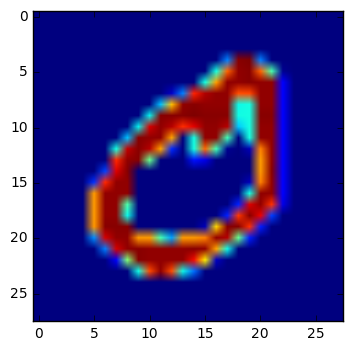

In [7]:
plt.imshow(trainset_import.train_data.numpy()[1])

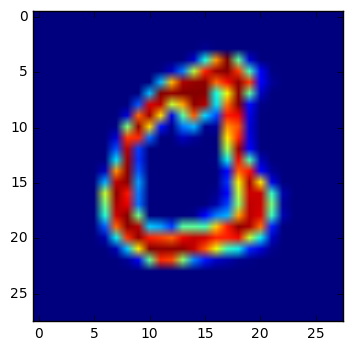

In [8]:
plt.imshow(elastic_transform(trainset_import.train_data.numpy()[1], alpha=34, sigma=4, random_state=None))

In [9]:
trainset_import_add_et=subMNIST(root='./data', train=True, download=True, transform=transform, k=6000)
trainset_import_add_et.train_data=torch.cat((trainset_import.train_data,dataaugment_elastic(trainset_import.train_data)),0)
trainset_import_add_et.train_labels=torch.cat((trainset_import.train_labels,trainset_import.train_labels),0)
pickle.dump(trainset_import_add_et, open("trainset_import_add_et.p", "wb" ))

Files already downloaded


In [22]:
trainset_unl_add_et=subMNIST(root='./data', train=True, download=True, transform=transform, k=94000)
trainset_unl_add_et.train_data=torch.cat((trainset_unl.train_data,dataaugment_elastic(trainset_unl.train_data)),0)
trainset_unl_add_et.train_labels=None
pickle.dump(trainset_unl_add_et, open("trainset_unl_add_et.p", "wb" ))

Files already downloaded


## Load Data
-Original Data

In [4]:
trainset_import = pickle.load(open("train_labeled.p", "rb"))
validset_import = pickle.load(open("validation.p", "rb"))
trainset_unl = pickle.load(open("train_unlabeled.p", "rb"))

## Neural Network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

model = Net()

In [6]:
train_loader = torch.utils.data.DataLoader(trainset_import, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset_import, batch_size=64, shuffle=True)
train_unl_loader = torch.utils.data.DataLoader(trainset_unl, batch_size=64, shuffle=True)

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [8]:
# CPU only training
def train(epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
    return 100. * correct / len(train_loader.dataset)

def test(epoch, valid_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:

        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(valid_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return 100. * correct / len(valid_loader.dataset)

In [9]:
"""
for test and debugging
"""
train_acc=[]
test_acc=[]
for epoch in range(1, 151):
    a=train(epoch)
    train_acc.append(a)
    test_acc.append(test(epoch, valid_loader))

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.297089
Train Epoch: 1 [640/3000 (21%)]	Loss: 2.308917
Train Epoch: 1 [1280/3000 (43%)]	Loss: 2.297300
Train Epoch: 1 [1920/3000 (64%)]	Loss: 2.309417
Train Epoch: 1 [2560/3000 (85%)]	Loss: 2.264054

Test set: Average loss: 2.2514, Accuracy: 3861/10000 (39%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 2.252442
Train Epoch: 2 [640/3000 (21%)]	Loss: 2.290858
Train Epoch: 2 [1280/3000 (43%)]	Loss: 2.303195
Train Epoch: 2 [1920/3000 (64%)]	Loss: 2.157901
Train Epoch: 2 [2560/3000 (85%)]	Loss: 2.227662

Test set: Average loss: 2.1460, Accuracy: 4396/10000 (44%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 2.201914
Train Epoch: 3 [640/3000 (21%)]	Loss: 2.132726
Train Epoch: 3 [1280/3000 (43%)]	Loss: 2.085429
Train Epoch: 3 [1920/3000 (64%)]	Loss: 2.093407
Train Epoch: 3 [2560/3000 (85%)]	Loss: 2.048476

Test set: Average loss: 1.8228, Accuracy: 5615/10000 (56%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 1.879835
Train Epoch: 4 [640/3000 (21%)]	Loss: 1.869594
Train Epoch: 4 [1280/

## Load Data
-with data augment

In [10]:
trainset_import2 = pickle.load(open("trainset_import_add_et.p", "rb"))
validset_import = pickle.load(open("validation.p", "rb"))
#trainset_unl2 = pickle.load(open("trainset_unl_add_et.p", "rb"))

In [11]:
trainset_import2.train_data.size()

torch.Size([6000, 28, 28])

In [12]:
trainset_import2.train_labels.size()

torch.Size([6000])

## Neural Network

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

model2 = Net()

In [44]:
train_loader2 = torch.utils.data.DataLoader(trainset_import2, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset_import, batch_size=64, shuffle=True)
#train_unl_loader2 = torch.utils.data.DataLoader(trainset_unl2, batch_size=64, shuffle=True)

In [45]:
len(train_loader2), len(trainset_import2),len(trainset_import2.train_data)

(94, 6000, 6000)

In [46]:
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [47]:
# CPU only training
def train2(epoch):
    model2.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader2):

        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model2(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader2.dataset),
                100. * batch_idx / len(train_loader2), loss.data[0]))
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
    return 100. * correct / len(train_loader2.dataset)

def test2(epoch, valid_loader):
    model2.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:

        data, target = Variable(data, volatile=True), Variable(target)
        output = model2(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(valid_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return 100. * correct / len(valid_loader.dataset)

In [48]:
"""
for test and debugging
"""
train_acc2=[]
test_acc2=[]
for epoch in range(1, 151):
    a=train2(epoch)
    train_acc2.append(a)
    test_acc2.append(test2(epoch, valid_loader))

Train Epoch: 1 [0/6000 (0%)]	Loss: 2.318392
Train Epoch: 1 [640/6000 (11%)]	Loss: 2.309527
Train Epoch: 1 [1280/6000 (21%)]	Loss: 2.314765
Train Epoch: 1 [1920/6000 (32%)]	Loss: 2.307153
Train Epoch: 1 [2560/6000 (43%)]	Loss: 2.294536
Train Epoch: 1 [3200/6000 (53%)]	Loss: 2.306432
Train Epoch: 1 [3840/6000 (64%)]	Loss: 2.298829
Train Epoch: 1 [4480/6000 (74%)]	Loss: 2.275490
Train Epoch: 1 [5120/6000 (85%)]	Loss: 2.275274
Train Epoch: 1 [5760/6000 (96%)]	Loss: 2.292466

Test set: Average loss: 2.2433, Accuracy: 3548/10000 (35%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 2.268384
Train Epoch: 2 [640/6000 (11%)]	Loss: 2.244417
Train Epoch: 2 [1280/6000 (21%)]	Loss: 2.266189
Train Epoch: 2 [1920/6000 (32%)]	Loss: 2.218234
Train Epoch: 2 [2560/6000 (43%)]	Loss: 2.223105
Train Epoch: 2 [3200/6000 (53%)]	Loss: 2.210933
Train Epoch: 2 [3840/6000 (64%)]	Loss: 2.217682
Train Epoch: 2 [4480/6000 (74%)]	Loss: 2.093439
Train Epoch: 2 [5120/6000 (85%)]	Loss: 2.133444
Train Epoch: 2 [5760/6000 (96%)]	Loss

### Based on the above tests, accuracy of the model increased about 2% when doubling the labeled data with elastic distortion

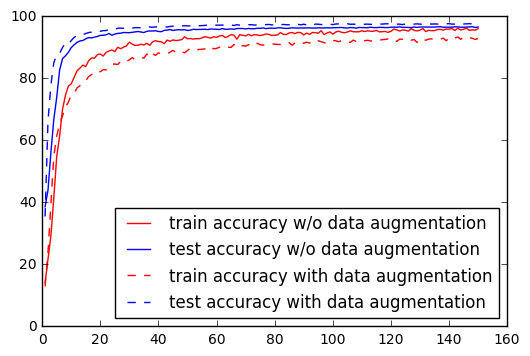

In [58]:
import matplotlib.pyplot as plt
x=list(range(1,151))
plt.plot(x, train_acc, 'r-',label='train accuracy w/o data augmentation')
plt.plot(x, test_acc,'b-' ,label='test accuracy w/o data augmentation')
plt.plot(x, train_acc2, 'r--',label='train accuracy with data augmentation')
plt.plot(x, test_acc2,'b--', label='test accuracy with data augmentation')
plt.legend(loc='lower right')
plt.ylim(0, 100)
plt.show()

In [60]:
np.savetxt("accuracy.csv", np.column_stack((train_acc, test_acc, train_acc2, test_acc2)), delimiter=",", fmt='%s')

In [ ]:
np.load()